In [0]:
# Importing required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from glob import glob
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model

In [2]:
# Reading folders present in google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [48]:
# Get the train and validation folders
main_folder = '/content/drive/My Drive/hymenoptera_data'
list_folders = []
for path in os.listdir(main_folder):
  list_folders.append(os.path.join(main_folder,path))

print(list_folders)

['/content/drive/My Drive/hymenoptera_data/train', '/content/drive/My Drive/hymenoptera_data/val']


In [0]:
# Set the variable for train and test folders
train_folder = list_folders[0]
test_folder = list_folders[1]

In [50]:
# Creating train and test transformations & agumentation
train_transform = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_transform = ImageDataGenerator(rescale = 1./255)



# Creating train and test dataloader
train_dataloader = train_transform.flow_from_directory(train_folder,target_size=(224, 224),batch_size=12,class_mode = 'categorical')
test_dataloader = test_transform.flow_from_directory(test_folder,target_size=(224,224),batch_size=12,class_mode='categorical')

Found 244 images belonging to 2 classes.
Found 153 images belonging to 2 classes.


In [51]:
# Initialize VGG16

IMAGE_SIZE = [224,224]
vgg = VGG16(include_top=False,weights='imagenet',input_shape=IMAGE_SIZE+[3])

print(vgg.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [52]:
# Making all the trainable parameter as flase as we donot want to train those , We will be using the pretrained weights from the IMAGENET
for layers in vgg.layers:
  layers.trainable = False
print(vgg.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
folders = glob(os.path.join(train_folder,'*'))
print(folders)

['/content/drive/My Drive/hymenoptera_data/train/bees', '/content/drive/My Drive/hymenoptera_data/train/ants']


In [0]:
# Creating our user defined last layer and adding with the existing model
x = Flatten()(vgg.output)
prediction = Dense(len(folders),activation='softmax')(x)
model = Model(inputs = vgg.input,outputs = prediction)

In [53]:
# Checking model summary for checking the layers
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# Compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [40]:
# Fitting the model
model_o = model.fit(train_dataloader,
                    validation_data = test_dataloader,
                    epochs  =10,
                    steps_per_epoch = len(train_dataloader),
                    validation_steps = len(test_dataloader))

Epoch 1/10
21/21 [==============================] - 170s 8s/step - loss: 0.7734 - accuracy: 0.6516 - val_loss: 0.5174 - val_accuracy: 0.7712
Epoch 2/10
21/21 [==============================] - 5s 252ms/step - loss: 0.3567 - accuracy: 0.8607 - val_loss: 0.3795 - val_accuracy: 0.8431
Epoch 3/10
21/21 [==============================] - 5s 254ms/step - loss: 0.2583 - accuracy: 0.8893 - val_loss: 0.4427 - val_accuracy: 0.8366
Epoch 4/10
21/21 [==============================] - 5s 253ms/step - loss: 0.1490 - accuracy: 0.9426 - val_loss: 0.5633 - val_accuracy: 0.7843
Epoch 5/10
21/21 [==============================] - 5s 254ms/step - loss: 0.1192 - accuracy: 0.9754 - val_loss: 0.4386 - val_accuracy: 0.8039
Epoch 6/10
21/21 [==============================] - 5s 255ms/step - loss: 0.0916 - accuracy: 0.9754 - val_loss: 0.6714 - val_accuracy: 0.7908
Epoch 7/10
21/21 [==============================] - 6s 262ms/step - loss: 0.0821 - accuracy: 0.9754 - val_loss: 0.3596 - val_accuracy: 0.8693
Epoch 8

       loss  accuracy  val_loss  val_accuracy
0  0.773423  0.651639  0.517357      0.771242
1  0.356675  0.860656  0.379501      0.843137
2  0.258295  0.889344  0.442712      0.836601
3  0.149019  0.942623  0.563343      0.784314
4  0.119150  0.975410  0.438592      0.803922
5  0.091609  0.975410  0.671382      0.790850
6  0.082134  0.975410  0.359551      0.869281
7  0.063380  0.975410  0.631831      0.790850
8  0.092908  0.975410  0.433554      0.849673
9  0.047615  0.991803  0.584299      0.784314


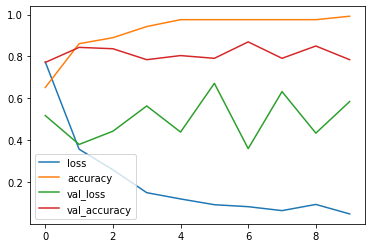

In [55]:
# Plotting the metrics 
# Note the scores are not upto the mark as this is a starter code and a CNN model needs more images to train and also the epoch are low in this model
model_history = pd.DataFrame(model_o.history)
print(model_history)
model_history.plot()